# Define the data structure

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('seaborn-v0_8-notebook')
random.seed(42)

card_properties = ['ID', 'D', 'S', 'due', 'delta_t',
                   'recall', 'last_date', 't_history', 'r_history']
dtypes = np.dtype([
    ('ID', int),
    ('D', float),
    ('S', float),
    ('due', int),
    ('delta_t', int),
    ('recall', float),
    ('last_date', int),
    ('t_history', str),
    ('r_history', str),
])

deck_size = 10000

df_card = pd.DataFrame(np.full(deck_size, np.nan, dtype=dtypes), index=range(
    deck_size), columns=card_properties)
df_card['ID'] = range(deck_size)
df_card['D'] = df_card['D'].map(
    lambda x: max(min(random.gauss(5.5, 2), 10), 1))
df_card['due'] = np.inf

revlog_properties = ['card_id', 'review_date', 'delta_t',
                     'rating', 't_history', 'r_history', 'stability', 'difficulty']
dtypes = np.dtype([
    ('card_id', int),
    ('review_date', int),
    ('delta_t', int),
    ('rating', int),
    ('t_history', str),
    ('r_history', str),
    ('difficulty', float),
    ('stability', float),
    ('retrievability', float),
])
df_revlog = pd.DataFrame(columns=revlog_properties)

/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


# Simulate the spaced repetition

In [2]:
card_per_day_limit = 200
learn_limit = 10
review_limit = 200
deck_size = 10000
learn_days = 3650


w = [
    0.4,
    0.9,
    2.3,
    10.9,
    4.93,
    0.94,
    0.86,
    0.01,
    1.49,
    0.14,
    0.94,
    2.18,
    0.05,
    0.34,
    1.26,
]


def init_stability(d):
    return w[0] + (10-d) / 3 * w[1]


def cal_next_recall_stability(s, r, d, rating):
    if rating == 1:
        return stability_after_success(s, r, d)
    else:
        return stability_after_failure(s, r, d)


def stability_after_success(s, r, d):
    return s * (
        1
        + np.exp(w[8])
        * (11 - d)
        * np.power(s, -w[9])
        * (np.exp((1 - r) * w[10]) - 1)
    )


def stability_after_failure(s, r, d):
    return np.maximum(
        0.1,
        np.minimum(
            w[11]
            * np.power(d, -w[12])
            * (np.power(s + 1, w[13]) - 1)
            * np.exp((1 - r) * w[14]),
            s,
        ),
    )


def scheduler(reps):
    ivl_list = [int(round(2.5**i+0.01) * 2) for i in range(1, 10)]
    return int(round(ivl_list[min(reps, len(ivl_list) - 1)] * random.randrange(95, 105) / 100))


df_card['reps'] = 0
new_card_per_day = np.array([0.0] * learn_days)

for day in tqdm(range(learn_days)):
    df_card['delta_t'] = day - df_card['last_date']
    df_card['recall'] = np.exp(np.log(0.9) * df_card["delta_t"] / df_card["S"])

    need_review = df_card[df_card['due'] <= day]
    for idx in need_review.sort_values('due').index[:review_limit]:
        df_card.loc[idx, 'last_date'] = day
        recall = df_card.loc[idx, 'recall']
        rating = 1 if random.random() < recall else 0
        df_card.loc[idx, 'reps'] = df_card.loc[idx,
                                               'reps'] + 1 if rating == 1 else 0
        df_revlog = pd.concat([df_revlog, pd.DataFrame({
            'card_id': idx,
            'review_date': day,
            'delta_t': df_card.loc[idx, 'delta_t'],
            'rating': rating,
            't_history': df_card.loc[idx, 't_history'],
            'r_history': df_card.loc[idx, 'r_history'],
            'difficulty': df_card.loc[idx, 'D'],
            'stability': df_card.loc[idx, 'S'],
            'retrievability': recall,
        }, index=[0])], ignore_index=True)
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 't_history'] += f",{df_card.loc[idx, 'delta_t']}"
        df_card.loc[idx, 'r_history'] += f",{rating}"
        df_card.loc[idx, 'S'] = cal_next_recall_stability(
            df_card.loc[idx, 'S'], recall, df_card.loc[idx, 'D'], rating)
        ivl = scheduler(df_card.loc[idx, 'reps'])
        # try:
        #     ivl = max(1, round(np.exp(df_card.loc[idx, 'S'] * np.log(request_recall) / np.log(0.9))))
        # except OverflowError:
        #     print(df_card.loc[idx, 'S'], recall)
        #     ivl = 10000
        df_card.loc[idx, 'due'] = day + ivl

    need_learn = df_card[df_card['r_history'] == '']
    for idx in need_learn.index[:min(learn_limit, max(0, card_per_day_limit - len(need_review)))]:
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 'S'] = init_stability(df_card.loc[idx, 'D'])
        df_revlog = pd.concat([df_revlog, pd.DataFrame({
            'card_id': idx,
            'review_date': day,
            'delta_t': 0,
            'rating': 0,
            't_history': "0",
            'r_history': "0",
            'difficulty': df_card.loc[idx, 'D'],
            'stability': df_card.loc[idx, 'S'],
            'retrievability': 0,
        }, index=[0])], ignore_index=True)
        df_card.loc[idx, 'last_date'] = day
        df_card.loc[idx, 't_history'] = "0"
        df_card.loc[idx, 'r_history'] = "0"
        # ivl = max(1, round(np.exp(df_card.loc[idx, 'S'] * np.log(0.9) / np.log(0.9))))
        ivl = scheduler(df_card.loc[idx, 'reps'])
        df_card.loc[idx, 'due'] = day + ivl
        new_card_per_day[day] += 1

  0%|          | 0/3650 [00:00<?, ?it/s]

/var/folders/20/_t6_h0cx4nl1qr58y1km9l740000gn/T/ipykernel_92629/120117357.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_revlog = pd.concat([df_revlog, pd.DataFrame({


# Visualize the distribution

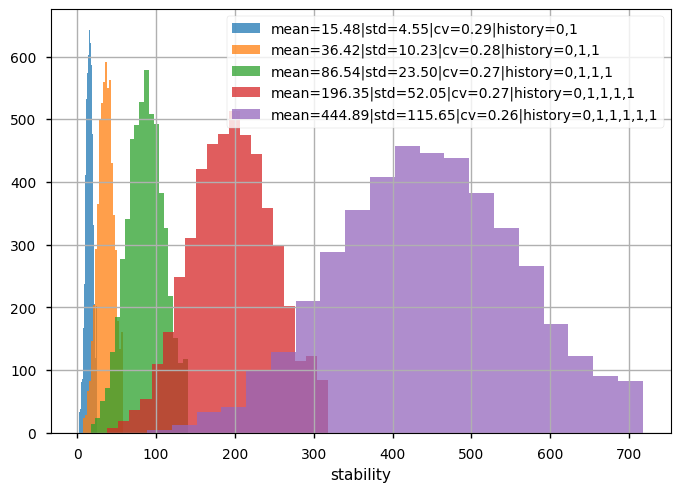

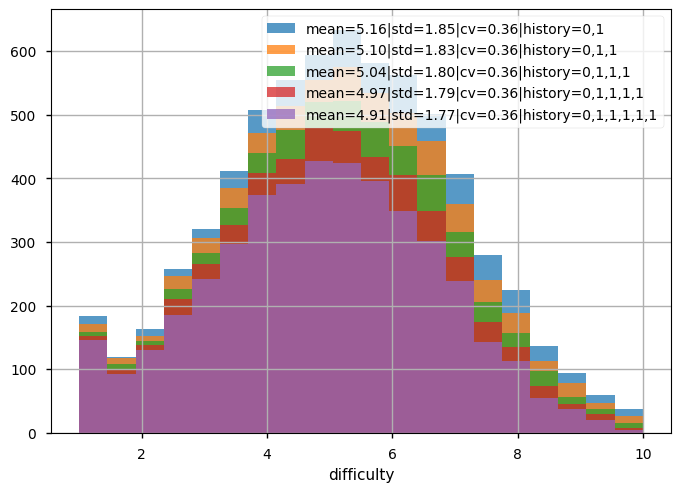

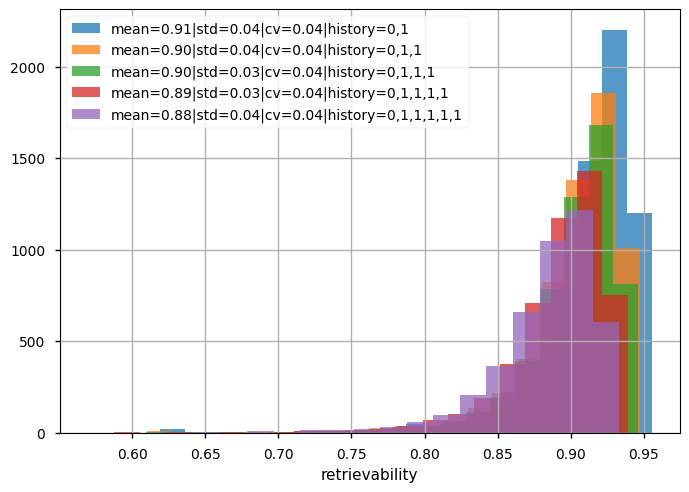

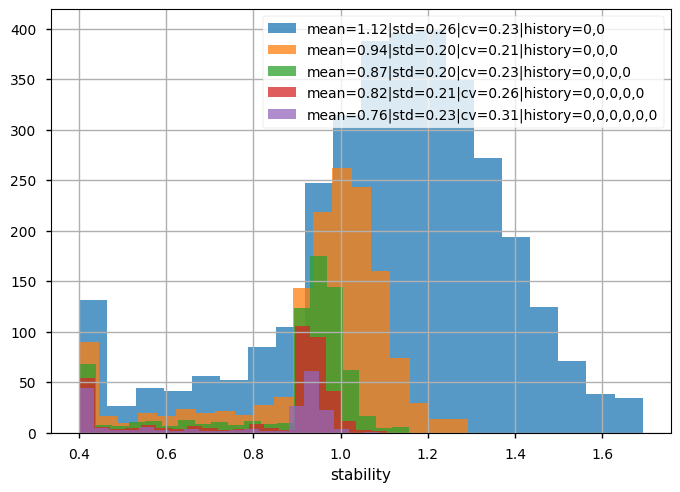

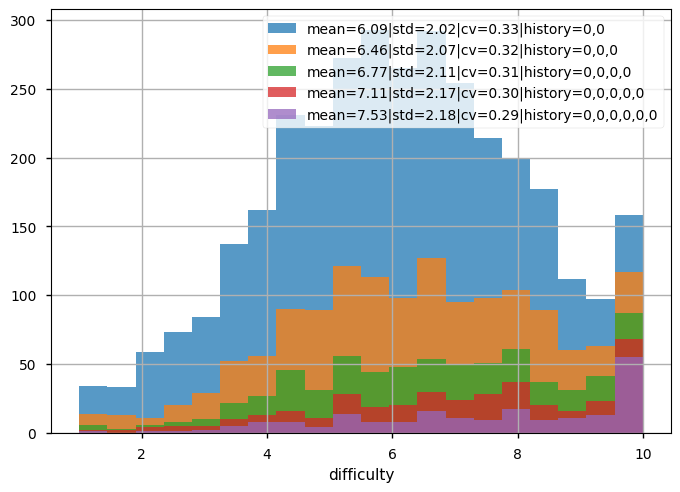

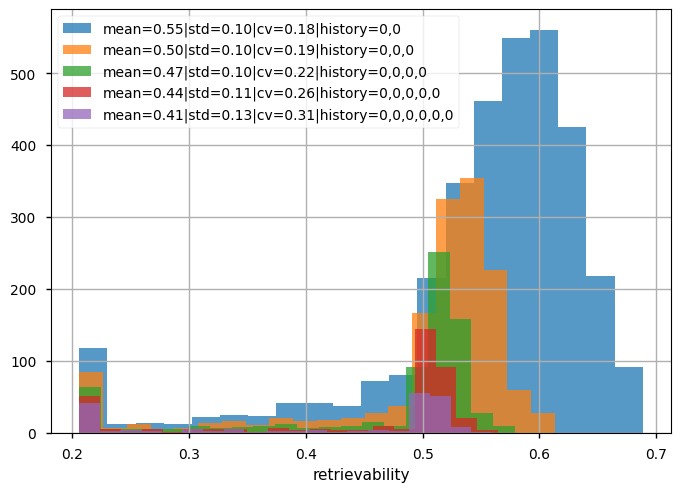

In [3]:
r_historys = (
    '0,1,1,1,1,1',
    '0,0,0,0,0,0'
)

for r_history in r_historys:
    r_seq = r_history.split(',')
    for i in range(1, len(r_seq)):
        r_subseq = ','.join(r_seq[0:i+1])
        s_mean = df_revlog[df_revlog['r_history']
                           == r_subseq]['stability'].mean()
        s_std = df_revlog[df_revlog['r_history']
                          == r_subseq]['stability'].std()
        s_cv = s_std / s_mean
        if pd.isna(s_cv):
            break
        plt.figure('stability')
        df_revlog[df_revlog['r_history'] == r_subseq]['stability'].hist(
            bins=20, alpha=0.75, label=f'mean={s_mean:.2f}|std={s_std:.2f}|cv={s_cv:.2f}|history={r_subseq}')
        plt.legend()
        plt.xlabel('stability')
        d_mean = df_revlog[df_revlog['r_history']
                           == r_subseq]['difficulty'].mean()
        d_std = df_revlog[df_revlog['r_history']
                          == r_subseq]['difficulty'].std()
        d_cv = d_std / d_mean
        plt.figure('difficulty')
        df_revlog[df_revlog['r_history'] == r_subseq]['difficulty'].hist(
            bins=20, alpha=0.75, label=f'mean={d_mean:.2f}|std={d_std:.2f}|cv={d_cv:.2f}|history={r_subseq}')
        plt.legend()
        plt.xlabel('difficulty')
        r_mean = df_revlog[df_revlog['r_history']
                           == r_subseq]['retrievability'].mean()
        r_std = df_revlog[df_revlog['r_history']
                          == r_subseq]['retrievability'].std()
        r_cv = r_std / r_mean
        plt.figure('retrievability')
        df_revlog[df_revlog['r_history'] == r_subseq]['retrievability'].hist(
            bins=20, alpha=0.75, label=f'mean={r_mean:.2f}|std={r_std:.2f}|cv={r_cv:.2f}|history={r_subseq}')
        plt.legend()
        plt.xlabel('retrievability')
    plt.show()